<center><h1>SegNet for Semantic Segmentation</h1></center>


*   SegNet is a deep learning network with encoder-decoder architecture for semantic segmentation and was researched and developed by members of the Computer Vision and Robotics Group at the University of Cambridge.
*   Segnet focuses on capturing and storing boundary information from encoder feature maps before sub-sampling. The more efficient way to store information is to store only the max-pooling indices, i.e, the locations of the maximum feature value in from feature map with a pooling window.<br> 
More information in Summary of literature survey [here](https://drive.google.com/file/d/1Z4GmACEY7tAy-MiailLezpC8104En1CB/view?usp=sharing)

<u>**Implementation Detail of Segnet:**</u><br>
<img src="https://imgur.com/0JcdJab.png">
*	SegNet has an encoder network and a corresponding decoder network, followed by a final pixel-wise classification layer. 
*	The encoder network consists of 13 convolutional layers that correspond to the first 13 convolutional layers in the VGG16 network designed for object classification and hence can initialize pre-trained weights.
*	Each encoder in the encoder network performs convolution with a filter bank to produce a set of feature maps that are batch normalized with ReLU. 
*	Followed by Max-pooling with a 2x2 window and stride 2 to get sub-sampled output by a factor of 2 where meanwhile max pool indices are memorized that is to capture and store boundary information of the feature maps.
*	The Decoder network upsamples its input feature map using the memorized max-pooling indices from the corresponding encoder feature map which results in sparse feature map and less number of parameters when compared to other architectures.
*	Followed by feature maps are then convolved with a trainable decoder filter bank to produce dense feature maps with batch normalization.
*	The final decoder output is fed to a multi-class softmax classifier to produce class probabilities for each pixel independently.
* For more information please refer the paper [SegNet Deep Convolutional Encoder-Decoder Architecture for Image Segmentation](https://arxiv.org/pdf/1511.00561.pdf)

### Importing required Modules

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from numpy import asarray,zeros,moveaxis
from tensorflow.keras.initializers import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
import matplotlib.pyplot as plt
from sys import getsizeof
from keras.callbacks import TensorBoard
from tqdm import tqdm_notebook,tqdm
from sklearn.metrics import *
import os,sys,ntpath,fnmatch,shutil,cv2
import joblib,os.path,itertools,warnings
from keras.models import load_model 
from scipy.sparse import csc_matrix
import numpy as np
import pandas as pd
from os import path
!pip install import_ipynb
from IPython.display import clear_output
from time import time
np.random.seed(0)
from google.colab import drive
drive.mount('/content/drive')
! cp -v "/content/drive/My Drive/IID_Files/Utility_Functions.ipynb" "/content" 
! cp -v "/content/drive/My Drive/IID_Files/Final.ipynb" "/content" 
! cp -v "/content/drive/My Drive/IID_Files/IID_Data_Prep_Utils.ipynb" "/content"  
warnings.filterwarnings("ignore")
clear_output()

### Importing Data Preparation Modules

In [ ]:
import import_ipynb 
from Utility_Functions import *
from Final import *
from IID_Data_Prep_Utils import *

Checking Status:
------------------------------------------------------
1.Image Data Preparation     .. .. .. >>> |Done| <1/5>
2.Label Mask Preparation     .. .. .. >>> |Done| <2/5>
3.Data Shuffling             .. .. .. >>> |Done| <3/5>
4.Data Train_Test_Split      .. .. .. >>> |Done| <4/5>
5.Loading Final Data         .. .. .. >>> |Done| <5/5>
------------------------------------------------------

Gen RAM Free: 2.41 GB  - Used: 23.22 GB - Total : 25.51 GB - Util  91.02 %
GPU RAM Free: 15.9 GB  - Used: 0.0 GB - Total : 15.9 GB  - Util  0.0 %


### General Utility Function for Prediction

In [ ]:
def predict_for(data_for_prediction, weights_save_path=False):

    """  General Function to perform prediction for the specified data split  """

    Mean_MIoU, Accuracy, cf_matrix=[], [], np.zeros((7,7))
    x, y = Load_For_Prediction(data_for_prediction)
    Model, Skip = Select_Model(weights_save_path), 2
    
    for d in tqdm_notebook(range(0,len(x),Skip)):

        if (d>=(len(x)-Skip)): 
            plot,_,_=True,clear_output(),print("Total number of samples in {0} : {1}".format(data_for_prediction,len(x)))
        else: plot=False
        
        Miou, cf_matrix, Accuracy=Function_2(x[d:d+Skip],y[d:d+Skip],Mean_MIoU,cf_matrix,Accuracy,Model,plot,False,False,False)
    collected = gc.collect()
    
    return Miou, Accuracy, cf_matrix

### Segnet Maxpooling and Unpooling with indices

In [ ]:
from keras.layers import *
from keras.models import *
import numpy as np

def MaxUnpooling2D(pool, ind, batch_size, name):

    """
    Function to perform UpSampling with Indices
    Input  : pool <tf.keras.layer>, ind <tf.keras.layer>, batch_size <Int>, name<String>
    Return : ret <tf.keras.layer> """

    # Reference:https://stackoverflow.com/questions/60104102/custom-max-pool-layer-valueerror-the-channel-dimension-of-the-inputs-should-be

    with tf.compat.v1.variable_scope(name):
        
        # Computing Upsampling Output Shape
        output_shape=[None,pool.shape[1]*2,pool.shape[2]*2,pool.shape[3]]
        
        # Flattening the pool tensor
        pool_ = tf.reshape(pool, [-1]) 

        # creating tensors to arrange indicies in batch wise 
        batch_range = tf.reshape(tf.range(batch_size, dtype=ind.dtype), [tf.shape(pool)[0], 1, 1, 1])
        b = tf.reshape(tf.ones_like(ind) * batch_range, [-1, 1])
        
        # Flattening the index tensor concating with tensor
        ind_ = tf.concat([b, tf.reshape(ind, [-1, 1])], 1)
        
        # Preforming Upsampling on pool tensor values with indicies  
        ret = tf.scatter_nd(ind_, pool_, shape=[batch_size, output_shape[1] * output_shape[2] * output_shape[3]])
        
        # Reshaping tensor according to Sample Size
        ret = tf.reshape(ret, [tf.shape(pool)[0], output_shape[1], output_shape[2], output_shape[3]])

        return ret

### Implementation of Segnet

In [ ]:
def Segnet_Segmentation(input_shape, n_labels, batch_size, Kernel=(3,3), Pool_Filter=(2,2), output_mode= "softmax"):
    
    """
    Function to build Segnet Architecture for Image Segmentation
    Input  : input_shape <Tuple>, n_labels <Int>, batch_size <Int>, Kernel <Tuple>, Pool_Filter <Tuple>, output_mode <String>
    Return : model """

    # Defining input_shape and Batch Size
    Inputs, batch_size = Input(shape=input_shape), batch_size


    def Segnet_Encoder(Block_Number, Filters, Input_layer):

        """
        Function to Build Segnet Encoder Blocks 
        Input  : Block_Number <Int>, Filters <Int>, Input_layer <Keras.layer>
        Return : Layer_2 <Keras.layer> """

        # Defining First Convolution layers with Batch Normalization for each Encoder Block     
        Layer_1 = Convolution2D(Filters, Kernel, name= "En_Block"+str(Block_Number)+"_Conv1", activation = 'relu', padding= "same",  kernel_initializer= "he_normal")(Input_layer)
        Layer_1 = BatchNormalization(name= "En_Block"+str(Block_Number)+"_Batch1")(Layer_1)

        # Defining Second Convolution layers with Batch Normalization for each Encoder Block     
        Layer_2 = Convolution2D(Filters, Kernel, name= "En_Block"+str(Block_Number)+"_Conv2", activation = 'relu', padding= "same",  kernel_initializer= "he_normal")(Layer_1)
        Layer_2 = BatchNormalization(name= "En_Block"+str(Block_Number)+"_Batch2")(Layer_2)

        if Block_Number>2:
            # Defining Third Convolution layers with Batch Normalization for necessary  Encoder Block     
            Layer_3 = Convolution2D(Filters, Kernel, name= "En_Block"+str(Block_Number)+"_Conv3", activation = 'relu', padding= "same",  kernel_initializer= "he_normal")(Layer_2)
            Layer_3 = BatchNormalization(name= "En_Block"+str(Block_Number)+"_Batch3")(Layer_3)

            if Block_Number==5:
                # Zero Padding of Feature map 
                Layer_3=ZeroPadding2D(((1,0),(0,0)), name='Zero_pad')(Layer_3)
            return Layer_3
        
        return Layer_2


    def Segnet_Decoder(Block_Number, Filters, Input_layer):

        """
        Function to Build Segnet Decoder Blocks 
        Input  : Block_Number <Int>, Filters <Int>, Input_layer <Keras.layer>
        Return : Layer_2 <Keras.layer> """
        
        # Defining Filters based on Decoder Block 
        Get_filter = lambda x : int(Filters/2) if (((Block_Number > 2 and Block_Number < 5) and (x==3)) or (Block_Number==2 and x==2)) else Filters

        if Block_Number==5:
            # Cropping of Feature map 
            Input_layer=Cropping2D(((1, 0),(0,0)))(Input_layer)

        # Defining First Convolution layers with Batch Normalization for each Decoder Block     
        Layer_1 = Convolution2D(Get_filter(1), Kernel, name= "Dec_Block"+str(Block_Number)+"_Conv1", activation = 'relu', padding= "same",  kernel_initializer= "he_normal")(Input_layer)
        Layer_1 = BatchNormalization(name= "Dec_Block"+str(Block_Number)+"_Batch1")(Layer_1)

        # Defining Second Convolution layers with Batch Normalization for each Decoder Block     
        Layer_2 = Convolution2D(Get_filter(2), Kernel, name= "Dec_Block"+str(Block_Number)+"_Conv2", activation = 'relu', padding= "same",  kernel_initializer= "he_normal")(Layer_1)
        Layer_2 = BatchNormalization(name= "Dec_Block"+str(Block_Number)+"_Batch2")(Layer_2)
    
        if Block_Number>2:
            # Defining Third Convolution layers with Batch Normalization for necessary Decoder Block     
            Layer_3 = Convolution2D(Get_filter(3), Kernel, name= "Dec_Block"+str(Block_Number)+"_Conv3", activation = 'relu', padding= "same",  kernel_initializer= "he_normal")(Layer_2)
            Layer_3 = BatchNormalization(name= "Dec_Block"+str(Block_Number)+"_Batch3")(Layer_3)
            return Layer_3
        
        return Layer_2


    # Building Encoder Block for Segnet with Various filters Sizes 
    Encoder_Conv1=Segnet_Encoder(1, 64, Inputs)
    max_pool1,pool_indices_1 =tf.nn.max_pool_with_argmax(Encoder_Conv1, [1, 2, 2, 1], [1, 2, 2, 1], padding="VALID")

    Encoder_Conv2=Segnet_Encoder(2, 128, max_pool1)
    max_pool_2,pool_indices_2 =tf.nn.max_pool_with_argmax(Encoder_Conv2, [1, 2, 2, 1], [1, 2, 2, 1], padding="VALID")

    Encoder_Conv3=Segnet_Encoder(3, 256, max_pool_2)    
    max_pool_3,pool_indices_3 =tf.nn.max_pool_with_argmax(Encoder_Conv3, [1, 2, 2, 1], [1, 2, 2, 1], padding="VALID")

    Encoder_Conv4=Segnet_Encoder(4, 512, max_pool_3)
    max_pool_4,pool_indices_4 =tf.nn.max_pool_with_argmax(Encoder_Conv4, [1, 2, 2, 1], [1, 2, 2, 1], padding="VALID")

    Encoder_Conv5=Segnet_Encoder(5, 512, max_pool_4)    
    max_pool_5,pool_indices_5 =tf.nn.max_pool_with_argmax(Encoder_Conv5, [1, 2, 2, 1], [1, 2, 2, 1], padding="VALID")


    # Building Decoder Block for Segnet with Various filters Sizes 
    Decoder_upsamp5 =MaxUnpooling2D(max_pool_5, pool_indices_5,  batch_size, name="un_pool_5")
    Decoder_Conv5=Segnet_Decoder(5, 512, Decoder_upsamp5)

    Decoder_upsamp4 =MaxUnpooling2D(Decoder_Conv5, pool_indices_4, batch_size, name="un_pool_4")  
    Decoder_Conv4=Segnet_Decoder(4, 512, Decoder_upsamp4)

    Decoder_upsamp3 =MaxUnpooling2D(Decoder_Conv4, pool_indices_3, batch_size, name="un_pool_3") 
    Decoder_Conv3=Segnet_Decoder(3, 256, Decoder_upsamp3)

    Decoder_upsamp2 =MaxUnpooling2D(Decoder_Conv3, pool_indices_2, batch_size, name="un_pool_2")   
    Decoder_Conv2=Segnet_Decoder(2, 128, Decoder_upsamp2)

    Decoder_upsamp1 =MaxUnpooling2D(Decoder_Conv2, pool_indices_1, batch_size, name="un_pool_1")   
    Decoder_Conv1=Segnet_Decoder(1, 64, Decoder_upsamp1)


    # Final Convolution layer has number of classes as filter size followed by softmax Layer
    Convolution_out = tf.keras.layers.Conv2D(n_labels, (3,3), name= "Final_Conv", activation = 'relu', kernel_initializer="he_normal", padding ='same')(Decoder_Conv1)
    Output=Activation('softmax', name="Softmax")(Convolution_out)


    # Invoke to get Segnet model 
    model = Model(inputs=Inputs, outputs=Output, name="SEGNET")

    return model

### Training Segnet Model

In [ ]:
# Get current Time
start_time = time()

# Defining Batch size and epoch 
batch_size, epochs = 16, 30

# Defining tensorboard to store Training Information and filepath to store Segnet model 
tensorboard, filepath = TensorBoard(log_dir=root+"logs/Segnet_{}".format(str(time())[5:10])), root+"Segnet.best.hdf5"

# Defining steps_per_epoch and validation_steps for Training
steps_per_epoch, validation_steps = int((len(train_img_files1)+len(train_img_files2))/batch_size),int((len(val_img_files1)+len(val_img_files2))/batch_size)

# Invoke Segnet_Segmentation to get Segnet Model
Segnet_Model = Segnet_Segmentation((240,480,3), 7, batch_size,Kernel=(3,3), Pool_Filter=(2, 2), output_mode= "softmax")

# Compile Segnet Model
Segnet_Model.compile(optimizer = tf.keras.optimizers.Adam(0.0001), loss = 'categorical_crossentropy',metrics = ['accuracy',miou])

# Defining EarlyStopping with patience=5 and monitor='val_miou'
es = EarlyStopping(monitor='val_miou', mode='max', verbose=1, patience=5)

# Defining ModelCheckpoint with monitor as 'val_miou'
checkpoint = ModelCheckpoint(filepath, monitor='val_miou', verbose=2, save_best_only=True, mode='max')

# Defining ReduceLROnPlateau to reduce learning rate with patience=3  
learning_rate_reduction = ReduceLROnPlateau(monitor='val_miou', patience=3, verbose=2, factor=0.2, min_lr=0.00001)

# Fit Segnet Model to start training 
history=Segnet_Model.fit_generator(train_batch_generator(batch_size,epochs), steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=1, validation_data=val_batch_generator(batch_size,epochs),
                            validation_steps=validation_steps, callbacks=[learning_rate_reduction,checkpoint,es,tensorboard])

# Printing Time taken for Training 
print("--- %s seconds ---" % (time() - start_time))

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
  1/876 [..............................] - ETA: 0s - loss: 2.1792 - accuracy: 0.1306 - miou: 0.0588WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
876/876 [==============================] - ETA: 0s - loss: 0.6153 - accuracy: 0.7792 - miou: 0.4374
Epoch 00001: val_miou improved from -inf to 0.46177, saving model to /content/drive/My Drive/Segnet2.best.hdf5
876/876 [==============================] - 2409s 3s/step - loss: 0.6153 - accuracy: 0.7792 - miou: 0.4374 - val_loss: 0.4914 - val_accuracy: 0.8156 - val_miou: 0.4618
Epoch 2/30
876/876 [==============================] - ETA: 0s - loss: 0.3991 - accuracy: 0.8478 - miou: 0.5519
Epoch 00002: val_miou improved from 0.46177 to 

### Segnet Training Results

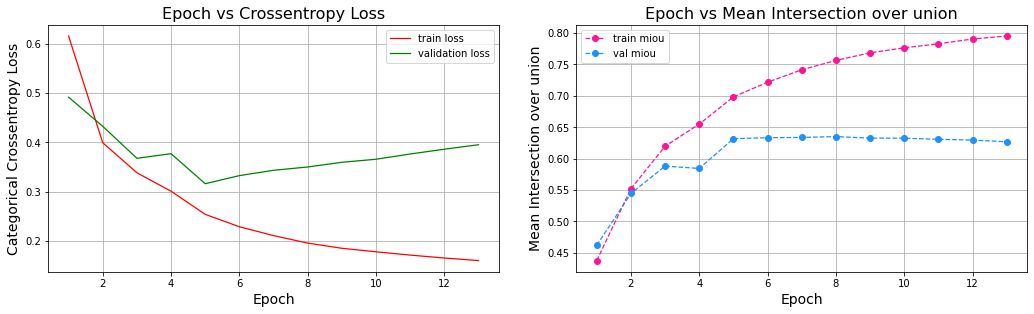

In [ ]:
# training_result
plot_training_result(history)

* The Lowest value of Validation Categorical Crossentopy is 0.3161 which is at epoch-5 as above in the Graph.
* The Best Value of Validation Mean Intersection Over Union is 0.6349 which is at epoch-8 as above in the Graph.
* Keras callback ModelCheckpoint is used to save the best Model during Training to avoid overfitting.

### Segnet Prediction on Train Data

Total number of samples in Train_data : 10016

Few Segmentation Samples:>>>



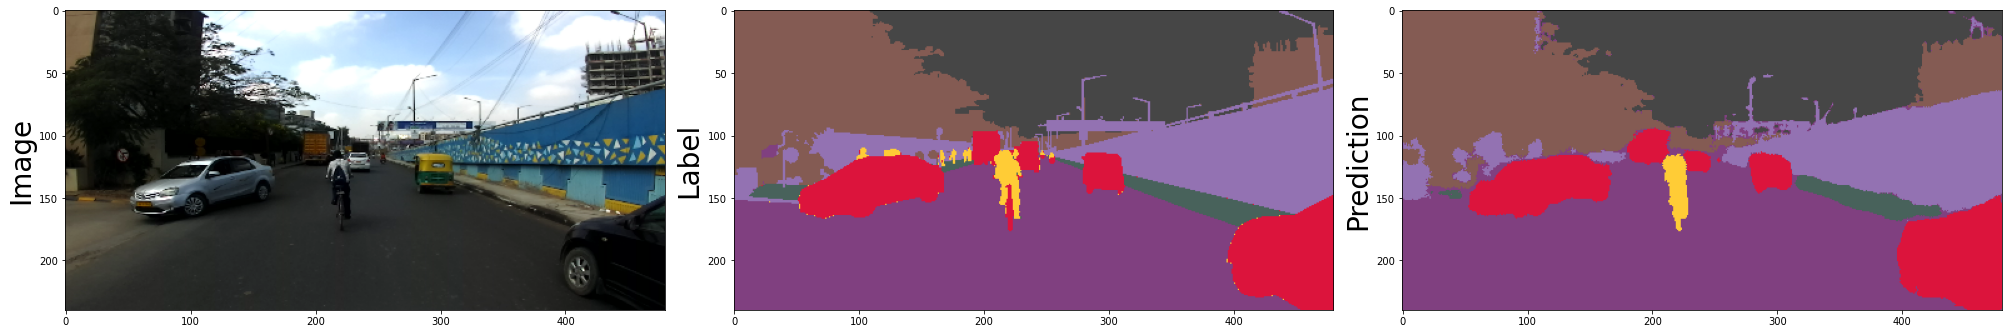

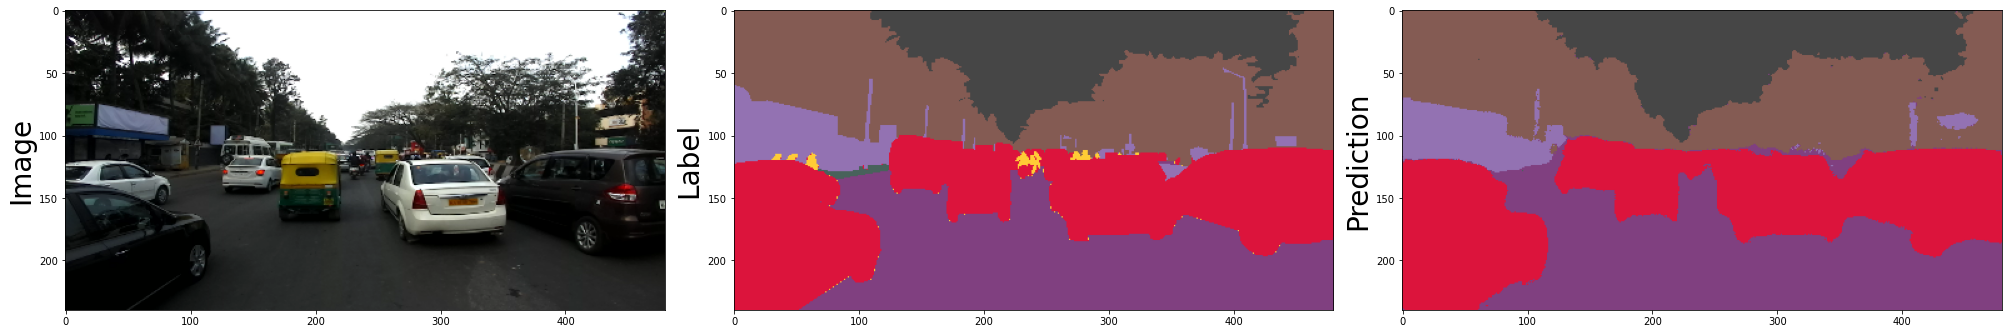


Printing Results:>>

-----------------------
|      MIOU Score     |
-----------------------

   MIOU Score: 0.6258

-----------------------
|   Accuracy Score   |
-----------------------

   Accuracy Score: 0.9154

-----------------------
|  Confusion Matrix   |
-----------------------


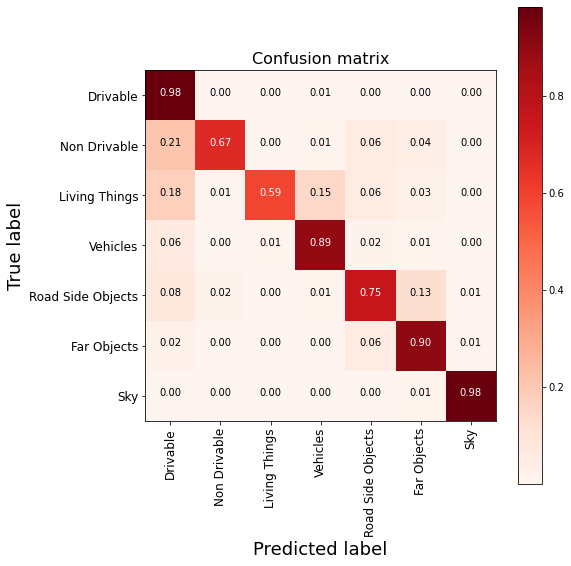

In [ ]:
# Train Prediction 
Miou, Accuracy, cf_matrix = predict_for("Train_data")

### Segnet Prediction on Validation Data

Total number of samples in Val_data : 2036

Few Segmentation Samples:>>>



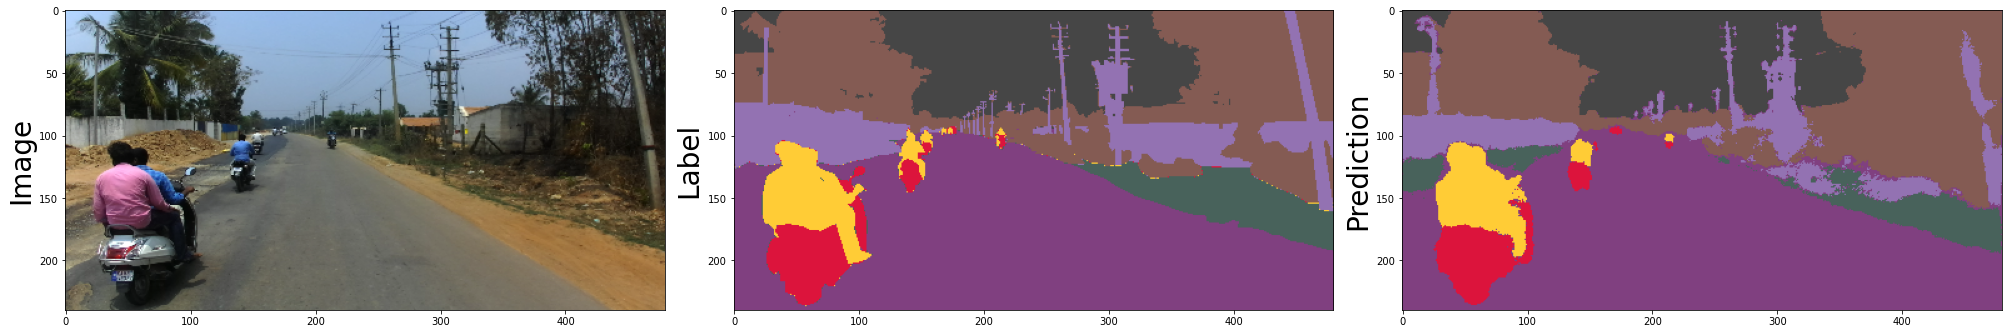

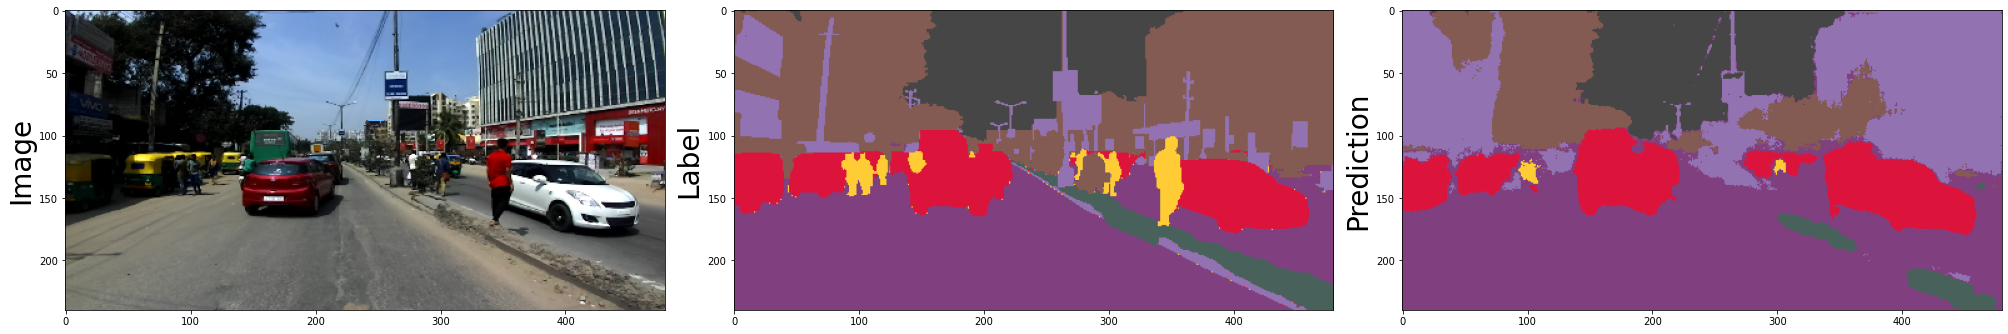


Printing Results:>>

-----------------------
|      MIOU Score     |
-----------------------

   MIOU Score: 0.5643

-----------------------
|   Accuracy Score   |
-----------------------

   Accuracy Score: 0.8698

-----------------------
|  Confusion Matrix   |
-----------------------


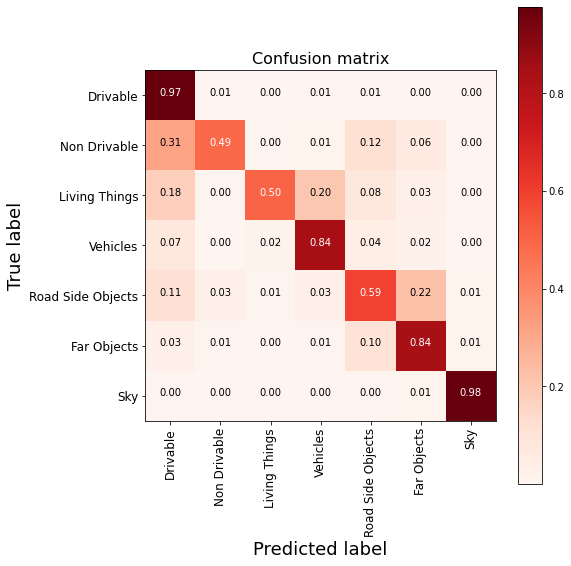

In [ ]:
# Validation Prediction 
Miou, Accuracy, cf_matrix = predict_for("Val_data")

### Segnet Prediction on Test Data

Total number of samples in Test_data : 4011

Few Segmentation Samples:>>>



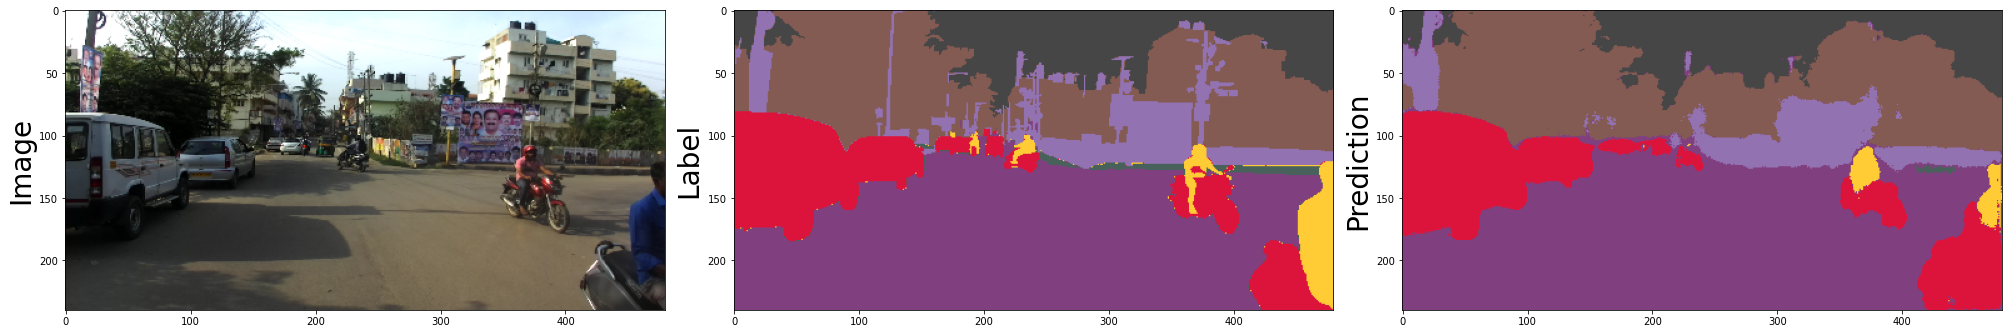


Printing Results:>>

-----------------------
|      MIOU Score     |
-----------------------

   MIOU Score: 0.5747

-----------------------
|   Accuracy Score   |
-----------------------

   Accuracy Score: 0.8814

-----------------------
|  Confusion Matrix   |
-----------------------


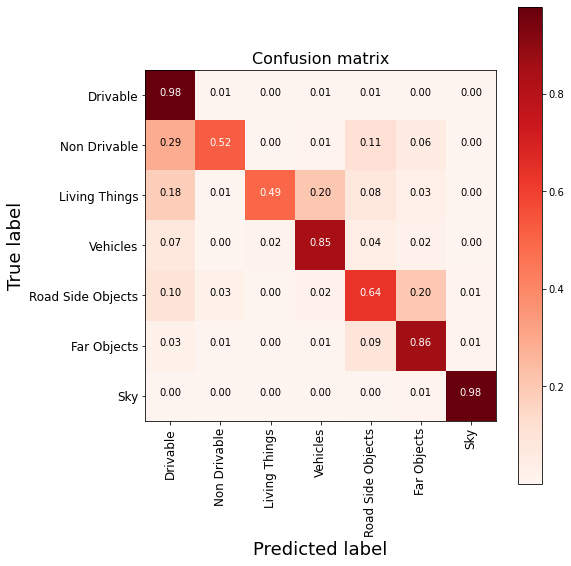

In [ ]:
# Test Prediction 
Miou, Accuracy, cf_matrix = predict_for("Test_data")

### Pretty Tabel


In [ ]:
# https://ptable.readthedocs.io/en/latest/tutorial.html
print("\n\t     Performance Table")
from prettytable import PrettyTable
T = PrettyTable()
T.field_names = ["SegNet","MIOU", "Accuracy"]
T.add_row(["Train ","0.6258","0.9154"])
T.add_row([" ---------- ","----------","----------"])
T.add_row(["Validation ","0.5643","0.8698"])
T.add_row([" ---------- ","----------","----------"])
T.add_row(["Test "," 0.5747","0.8814"])
print(T)


	     Performance Table
+--------------+------------+------------+
|    SegNet    |    MIOU    |  Accuracy  |
+--------------+------------+------------+
|    Train     |   0.6258   |   0.9154   |
|  ----------  | ---------- | ---------- |
| Validation   |   0.5643   |   0.8698   |
|  ----------  | ---------- | ---------- |
|    Test      |   0.5747   |   0.8814   |
+--------------+------------+------------+


### <u>**Conclusion:**</u>
* SegNet is an Encoder-Decoder Network which is efficient both in terms of memory and computational time
* SegNet focuses on the need to map low-resolution features to input resolution for Image Segmentation.
* SegNet stores the max-pooling indices of the feature maps and uses them in its decoder network to achieve good performance as above.
* The SegNet architecture achieves relatively good performance on Image segmentation when compared to other segmentation models.
* More performance can be obtained by training Models with data in high resolution with more powerful hardware resources
